In [2]:
print("hello")

hello


In [3]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob
import re
import math
print("hello")
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print("hello")
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
print("hello")
import torch
torch.set_default_dtype(torch.float64)
print("hello")
import e3nn
print("hello")
import e3nn.point.data_helpers as dh 
from training_utils import *
print("bye")

hello
hello
hello
hello
hello


In [4]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
#print(torch.cuda.memory_summary())
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


In [5]:
# all expected elements
all_elements = ['C', 'H', 'N', 'O', 'S']
n_elements = len(all_elements)

# so we can normalize training data for the nuclei to be predicted
elementwide_scaling_factors = { "C" : (118.0, 51.0),    # element : (mean, stdev)
                                "H" : (29.0, 2.0)  }
relevant_elements = list(elementwide_scaling_factors.keys())

# irrelevant atoms will not be scaled
for element in all_elements:
    if element not in elementwide_scaling_factors:
        elementwide_scaling_factors[element] = (0.0,1.0)

In [6]:
# create a function to noramlize the shieldings for a specific molecule
# shielding -> (shielding-mean)/stdev or 0 if not a relevant element
def get_scalings(atomic_symbols):
    scaling_factors = [ elementwide_scaling_factors[a] for a in atomic_symbols ]
    scaling_factors = np.array(scaling_factors)
    def scaling_function(x):
        result = x - scaling_factors[:,0]
        result = result / scaling_factors[:,1]
        return result
    return scaling_factors, scaling_function
    
# generates one-hots for a list of atomic_symbols
def get_one_hots(atomic_symbols):
    one_hots = []
    for symbol in atomic_symbols:
        inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
        one_hots.append(inner_list)
    return np.array(one_hots)

# compute weights for loss function
def get_weights(atomic_symbols, symmetrical_atoms):
    weights = [ 1.0 if symbol in relevant_elements else 0.0 for symbol in atomic_symbols ]
    weights = np.array(weights)
    for l in symmetrical_atoms:
        weight = 1.0/len(l)
        for i in l:
            weights[i] = weight
    return weights

In [7]:
# represents the training data for one molecule
# all of these items are stored on the cpu
class Molecule():
    def __init__(self, name,               
                 atomic_symbols,           
                 symmetrical_atoms,        # list of lists of 0-indexed atom numbers
                 perturbed_geometries,               
                 stationary_shieldings,
                 perturbed_shieldings):    
        self.name = name                                                     # name of molecule
        self.atomic_symbols = atomic_symbols                                 # vector of strings of length n_atoms
        self.n_atoms = len(atomic_symbols)                                   # number of atoms
        self.perturbed_geometries = perturbed_geometries                     # (n_examples, n_atoms, 3)
        self.stationary_shieldings = stationary_shieldings                   # (n_examples, n_atoms, 1)
        
        scaling_factors, scaling_function = get_scalings(atomic_symbols)
        self.scaling_factors = scaling_factors                               # (n_atoms, 2) inner axis is mean, stdev
        self.scaling_function = scaling_function                             # unscaled shieldings --> scaled shieldings 

        # scale perturbed shieldings and zero out data for irrelevant atoms
        perturbed_shieldings = self.scaling_function(perturbed_shieldings)
        for i,a in enumerate(atomic_symbols):
            if a not in relevant_elements:
                perturbed_shieldings[:,i]=0.0
        self.perturbed_shieldings = perturbed_shieldings                     # (n_examples, n_atoms, 1)
        
        self.features = get_one_hots(atomic_symbols)                         # (n_atoms, n_elements)
        self.weights = get_weights(atomic_symbols, symmetrical_atoms)        # (n_atoms,)

In [8]:
molecules_dict = {}  # name -> Molecule
with h5py.File("qm7.hdf5", "r") as h5:
    for dataset_name,geometries_and_shieldings in h5.items():
        if not dataset_name.startswith("data_"):
            continue
        dataset_number = dataset_name.split("_")[1]
        geometries_and_shieldings = np.array(geometries_and_shieldings)
        perturbed_geometries = geometries_and_shieldings[:,:,:3]
        perturbed_shieldings = geometries_and_shieldings[:,:,3]
        assert np.shape(geometries_and_shieldings)[2] == 4
        stationary_shieldings = h5.attrs[f"stationary_{dataset_number}"]
        n_atoms = len(stationary_shieldings)
        assert np.shape(geometries_and_shieldings)[1] == n_atoms
        atomic_symbols = h5.attrs[f"atomic_symbols_{dataset_number}"]
        for a in atomic_symbols:
            assert a in all_elements, f"need to add {a} to all_elements"
        assert len(atomic_symbols) == n_atoms
        symmetrical_atoms_group = h5.get(f"symmetrical_atoms_{dataset_number}")
        symmetrical_atoms = []
        for a,b in symmetrical_atoms_group.items():
            b = [ i-1 for i in b ]
            for i in b:
                assert 0 <= i < n_atoms
            symmetrical_atoms.append(b)    
                # store the results
        molecule = Molecule(dataset_number, atomic_symbols, symmetrical_atoms,
                            perturbed_geometries, stationary_shieldings, perturbed_shieldings)
        molecules_dict[dataset_number] = molecule
        
molecules = np.array(list(molecules_dict.values()))
print(f"There are {len(molecules)} molecules.")

There are 144 molecules.


(73656,)
0.007759818919402491
1.0019581739943288
(124938,)
-0.06790754738550761
1.0218088804836765


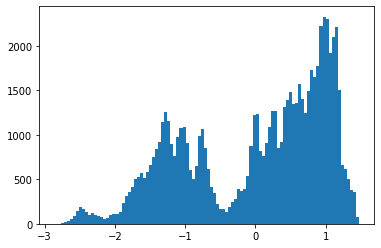

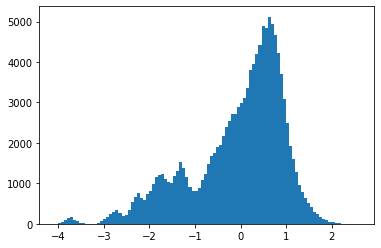

In [9]:
# get stats
all_shieldings = {}
for molecule in molecules:
    atomic_symbols = molecule.atomic_symbols
    perturbed_shieldings = molecule.perturbed_shieldings
    for i,symbol in enumerate(atomic_symbols):
        if symbol in relevant_elements:
            if symbol not in all_shieldings:
                all_shieldings[symbol] = []
            shieldings_list = all_shieldings[symbol]
            current_shieldings = shieldings_list.extend(perturbed_shieldings[:,i])
shieldingsC = all_shieldings["C"]
print(np.shape(shieldingsC))
print(np.mean(shieldingsC))
print(np.std(shieldingsC))
shieldingsH = all_shieldings["H"]
print(np.shape(shieldingsH))
print(np.mean(shieldingsH))
print(np.std(shieldingsH))
plt.hist(shieldingsC,bins=100)
plt.show()
plt.hist(shieldingsH,bins=100)
plt.show()

In [10]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 4.0

In [11]:
def create_torch_dataset(molecules):
    dataset = []
    n_molecules = len(molecules)
    for i,molecule in enumerate(molecules):
        features = torch.tensor(molecule.features, dtype=torch.float64)
        features.to(device)
        weights = torch.tensor(molecule.weights, dtype=torch.float64)
        weights.to(device)
        n_to_save = len(molecule.perturbed_geometries)
        for j in range(n_to_save):
            if j == 0 or (j+1) % 50 == 0 or j == n_to_save - 1:
                print(f"Processing geometry {j+1:5d}/{n_to_save:5d} for molecule {molecule.name:5s} ({i+1:5d}/{n_molecules:5d})...           ", end='\r', flush=True)
            g = torch.tensor(molecule.perturbed_geometries[j,:,:], dtype=torch.float64)
            s = torch.tensor(molecule.perturbed_shieldings[j], dtype=torch.float64).unsqueeze(-1)  # [1,N]
            data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                    self_interaction=True, name=molecule.name,
                                    weights=weights, y=s, Rs_out = Rs_out)
            dataset.append(data)
    print("\ndone!")
    return dataset


In [12]:
# split into train and test molecules
# then preprocess the neighbor data
training_molecules, testing_molecules = train_test_split(molecules, train_size=100, test_size=10, random_state=1)
training_dataset = create_torch_dataset(training_molecules)
testing_dataset = create_torch_dataset(testing_molecules)

done!ssing geometry    99/   99 for molecule 2220  (  100/  100)...           
done!ssing geometry    99/   99 for molecule 5820  (   10/   10)...           


In [14]:
# mean-squared loss
def loss_function(output, data):
    predictions = output
    observations = data.y
    weights = data.weights
    normalization = weights.sum()
    residuals = (predictions-observations)
    loss = residuals.square() * weights
    loss = loss.sum() / normalization
    loss = loss.pow(0.5)
    return loss, residuals

In [15]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 3,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 3,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel?
}
model = model_from_kwargs(model_kwargs)
model.to(device);

In [16]:
# training parameters
learning_rate = 1e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
epochs = 100       
n_norm = 7           # n_norm is average number of convolution neighbors per atom
batch_size = 50

In [17]:
# prepare to train model
torch.cuda.empty_cache()

training_size = len(training_dataset)
n_training_batches = int(training_size / batch_size)
training_dataloader = tg.data.DataListLoader(training_dataset, batch_size=batch_size, shuffle=True)

testing_size = len(testing_dataset)
n_testing_batches = int(testing_size / batch_size)
testing_dataloader = tg.data.DataListLoader(testing_dataset, batch_size=batch_size, shuffle=False)

results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
history = []      # index is epoch, items are (train_loss, test_loss)

In [18]:
# train model
start_time = time.time()
for i in range(epochs):
    start_time = time.time()
    
    # training
    training_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(training_dataloader):
        # forward pass
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss, residuals = loss_function(output, data)
        
        # backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # update training loss
        temp_loss = loss.detach()
        training_loss_cum += loss.detach().pow(2)
        current_cum = np.sqrt(training_loss_cum.item() / (j+1))
        print(f"Iteration {i+1:<4d}    train {j+1:5d} / {n_training_batches:5d}  loss = {temp_loss.item():12.3f}    cum_loss = {current_cum:12.3f}            ", end="\r", flush=True)
        
    training_loss_cum = np.sqrt((training_loss_cum.item()/(j+1)))
    
    # testing
    testing_loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(testing_dataloader):
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        
        with torch.no_grad():
            # run model
            output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)

            # compute MSE
            loss, residuals = loss_function(output,data)
            testing_loss_cum += loss.pow(2)
        print(f"Iteration {i+1:<4d}    test {j+1:5d} / {n_testing_batches:5d}  loss = {loss.item():12.3f}                                  ", end="\r", flush=True)
    
    testing_loss_cum = np.sqrt((testing_loss_cum.item()/(j+1)))
    end_time = time.time()
    elasped_time = end_time - start_time
    history.append((training_loss_cum, testing_loss_cum))
    print(f"Iteration {i+1:<4d}        training = {training_loss_cum.item():<12.3f}    testing = {testing_loss_cum.item():<12.3f}     elapsed = {elasped_time:7.2f} s                     ", end="\r", flush=True)
    print()
    #if i == 0 or (i+1) % 10 == 0:
    #    print()

Iteration 1           training = 17.457          testing = 15.247           elapsed =   16.10 s                     
Iteration 2           training = 8.074           testing = 11.349           elapsed =   11.05 s                     
Iteration 3           training = 5.536           testing = 10.082           elapsed =   11.06 s                     
Iteration 4           training = 4.485           testing = 9.668            elapsed =   11.01 s                     
Iteration 5           training = 3.912           testing = 9.194            elapsed =   10.98 s                     
Iteration 6           training = 3.555           testing = 8.989            elapsed =   11.05 s                     
Iteration 7           training = 3.261           testing = 8.671            elapsed =   10.99 s                     
Iteration 8           training = 3.085           testing = 8.520            elapsed =   10.99 s                     
Iteration 9           training = 2.868           testing = 8.415

Iteration 71          training = 1.268           testing = 6.152            elapsed =   10.97 s                     
Iteration 72          training = 1.274           testing = 6.187            elapsed =   10.96 s                     
Iteration 73          training = 1.255           testing = 6.083            elapsed =   11.00 s                     
Iteration 74          training = 1.259           testing = 6.086            elapsed =   10.99 s                     
Iteration 75          training = 1.255           testing = 6.156            elapsed =   10.98 s                     
Iteration 76          training = 1.237           testing = 6.107            elapsed =   10.96 s                     
Iteration 77          training = 1.229           testing = 6.061            elapsed =   10.95 s                     
Iteration 78          training = 1.226           testing = 6.077            elapsed =   10.95 s                     
Iteration 79          training = 1.228           testing = 6.029

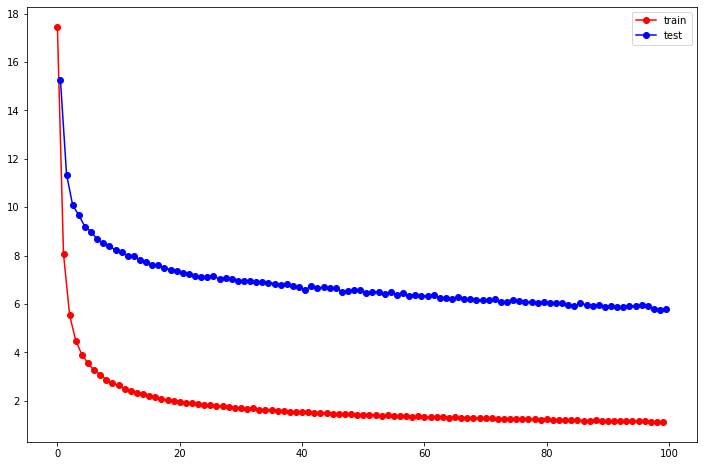

In [19]:
# plot learning curve
plt.figure(figsize=(12,8))
epoch = list(range(len(history)))
epoch = np.array(epoch)
epoch2 = epoch + 0.5
training_loss = [ training for training,testing in history ]
testing_loss = [ testing for training,testing in history ]
plt.plot(epoch, training_loss, "ro-", label="train")
plt.plot(epoch2, testing_loss, "bo-", label="test")
plt.legend(loc="best")
plt.show()

In [20]:
# test the model as it now
torch.cuda.empty_cache()
n_batches = math.ceil(testing_size / batch_size)
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
start_time = time.time()

loss_cum = torch.tensor([0.]).to(device)
for j,data in enumerate(testing_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        # run model
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        
        # compute MSE
        loss, residuals = loss_function(output,data)
        loss_cum += loss.pow(2)
        
        # rescale residuals back to ppm and store
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors[:,1]
            results_dict[name].append(subset)
            i += n_atoms
            
loss_cum = loss_cum/(j+1)
loss_cum = loss_cum.pow(0.5)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum.item():.6f}.  Evaluation took {elasped_time:.2f} s.")

batch    20 /    20
Overall loss is 5.809075.  Evaluation took 0.58 s.


In [21]:
for name,results in results_dict.items():
    print(name)
    print(results[0])
    print(np.shape(results))
    break

520
[ 0.052327   -3.55370537 12.64118632  9.91077613 13.105895   13.6395218
 -0.60952119 -0.5706094  -0.94286104  0.47578755  0.39099945  0.41295507
  0.56686169]
(99, 13)


In [26]:
# results_dict : molecule name -> residuals (n_examples,n_atoms)
# results_dict2 : site label -> residuals
results_dict2 = {}
all_residuals = {}  # element --> [residuals]
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for atomic_index,this_result in enumerate(results):
        element = atomic_symbols[atomic_index]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{atomic_index+1}"
        results_dict2[label]=this_result
        if element not in all_residuals:
            all_residuals[element] = []
        all_residuals[element].extend(this_result)

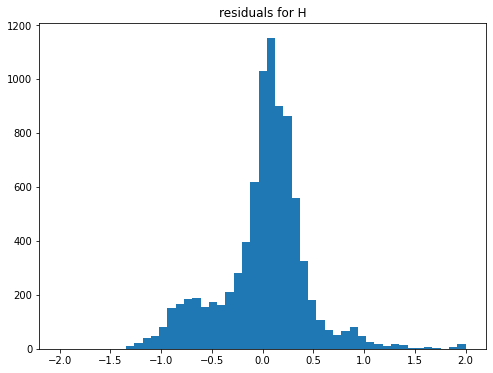

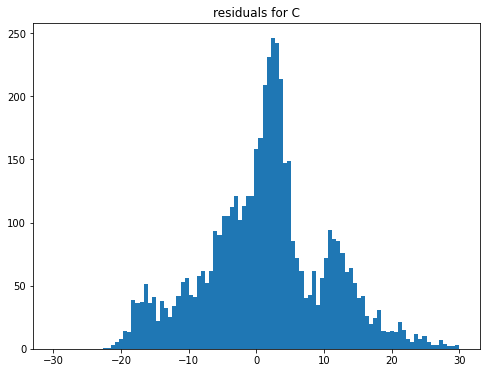

In [33]:
e="H"
bins = np.linspace(-2,2,50)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()
e="C"
bins = np.linspace(-30,30,100)
plt.figure(figsize=(8,6))
plt.title(f"residuals for {e}")
plt.hist(all_residuals[e],bins=bins)
plt.show()

In [40]:
# get stats on everything
for e in relevant_elements:
    mean_error = np.mean(all_residuals[e])
    RMSE = np.sqrt(np.mean(np.square(all_residuals[e])))
    min_err = np.min(all_residuals[e])
    max_err = np.max(all_residuals[e])
    print(f"{e}:  mean ={mean_error:7.3f}  RMSE ={RMSE:7.3f}   range = {min_err:7.2f} to {max_err:7.2f}")

C:  mean =  1.378  RMSE =  9.159   range =  -22.31 to   36.55
H:  mean =  0.033  RMSE =  0.476   range =   -1.36 to    2.61


In [34]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = np.sqrt(df.pow(2).mean())
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

,mean,range,RMSE
520_C2,-7.98,21.18,8.53
520_C3,13.45,15.79,13.76
520_C4,11.61,9.52,11.79
520_C5,11.51,11.70,11.75
520_C6,12.78,13.59,13.12
...,...,...,...
5820_H11,0.28,0.52,0.30
5820_H12,0.37,0.51,0.39
5820_H13,-0.15,0.39,0.17
5820_H14,0.22,0.27,0.23


In [ ]:
def save_model(model_kwargs, model, filename, optimizer=None):
    model_dict = {
        'state_dict': model.state_dict(),
        'model_kwargs': model_kwargs
    }
    if optimizer is not None:
        model_dict['optimizer_state_dict'] = optimizer.state_dict()
    torch.save(model_dict, filename)

In [ ]:
save_model(model_kwargs, model, "small-model2.torch", optimizer=opt)